In [94]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
path = Path.home() / 'RANCZLAB-NAS/iakov/data/mnist'

# mnist_trainset = datasets.MNIST(root=path, train=True, download=False, transform=None)
# mnist_testset = datasets.MNIST(root=path, train=False, download=False, transform=None)

In [96]:
column_names = ['labels']+[i for i in range(28*28)]
train_df = pd.read_csv(path/'mnist_train.csv', names = column_names)
test_df = pd.read_csv(path/'mnist_test.csv', names = column_names)

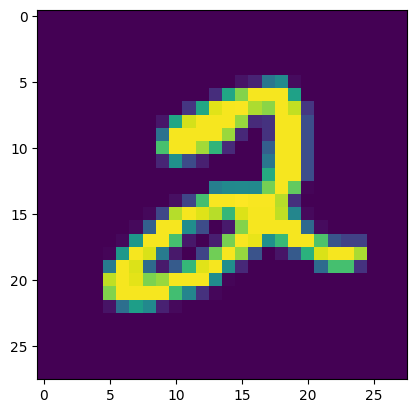

In [97]:
plt.imshow(train_df.iloc[5].to_numpy()[1:].reshape((28,28)))

In [98]:
digit_duration = 1 # seconds
in_between_digit_period = 1 # seconds
number_of_digits = 10
sampling_freq = 10 # Hz

total_time = number_of_digits * digit_duration + (number_of_digits + 1) * in_between_digit_period
t = np.linspace(0, total_time, int(total_time*sampling_freq))

In [99]:
print(t.shape)

(210,)


In [100]:
df_arr = train_df.to_numpy()
df_arr.shape

(60000, 785)

In [101]:
digits = {k:[] for k in range(10)}

for i in range(df_arr.shape[0]):
    digits[df_arr[i,0]].append(df_arr[i,1:].reshape((28,28)))
    
digits = {k:np.array(v) for k,v in digits.items()}

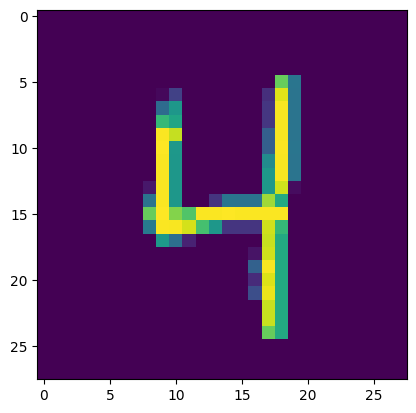

In [102]:
plt.imshow(digits[4][10])

In [103]:
l = []
for k in digits.keys():
    l.append(digits[k].shape[0])
print(l)
min_seqs = min(l)
print('Minimum number of unique digits =', min_seqs)

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Minimum number of unique digits = 5421


In [104]:
min_seqs = 1000

In [105]:
def get_next_ind(current_ind):
    if current_ind < 9:
        next_ind = current_ind + 1
    elif current_ind == 9:
        next_ind = 0
    return next_ind

In [127]:
sequences = []
for starting_digit in range(10): # loop of starting digits
    for unique_seq_i in range(min_seqs): # loop of unique digit repetitions
        
        new_sequence = np.zeros((t.shape[0], 28, 28))

        ind = starting_digit
        time_ind = 0
        
        for seq_i in range(10): # inner sequence loop
            time_ind += in_between_digit_period * sampling_freq
            new_digit = digits[ind][unique_seq_i]
            new_sequence[time_ind:(time_ind+digit_duration*sampling_freq), :, :] = new_digit
            time_ind += digit_duration * sampling_freq
            ind = get_next_ind(ind)
        sequences.append(new_sequence)
sequences = np.array(sequences).astype(np.int16) # 0-255 range of np.int8 is most suitable, but for some reason it changes the values

In [128]:
sequences[0].shape

(210, 28, 28)

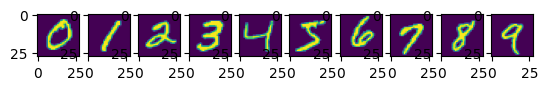

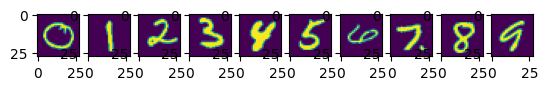

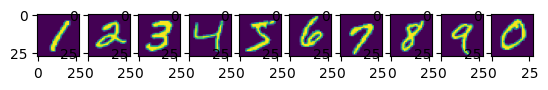

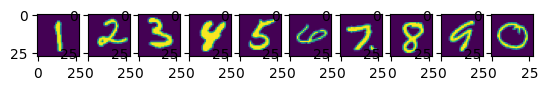

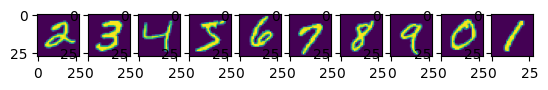

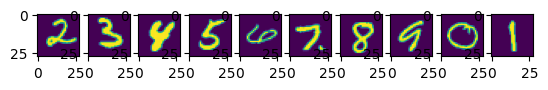

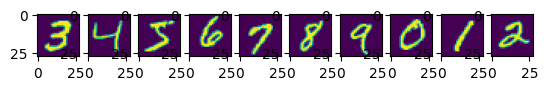

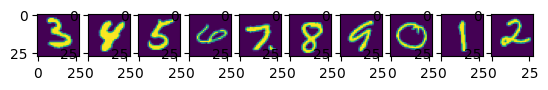

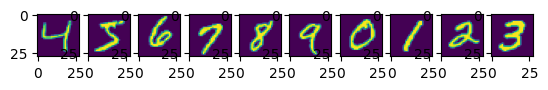

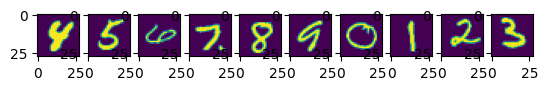

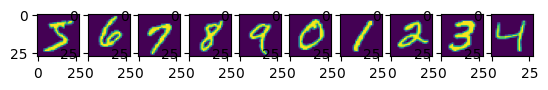

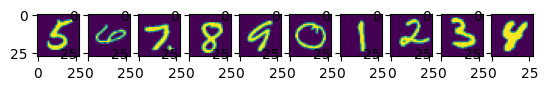

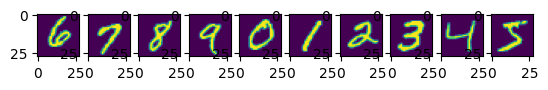

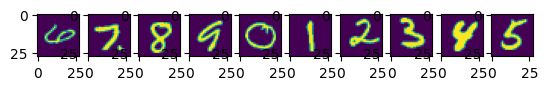

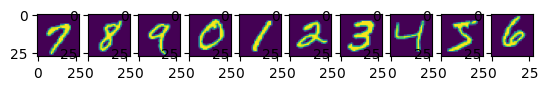

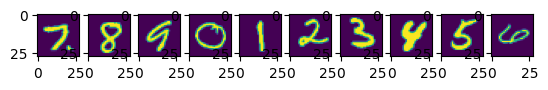

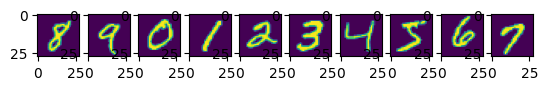

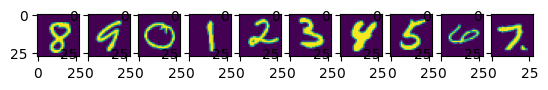

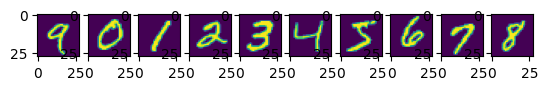

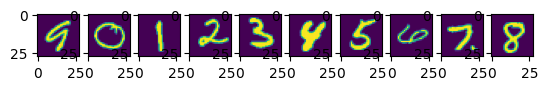

In [129]:
seq_inds = [0,999,1000,1999,2000,2999,3000,3999,4000,4999,5000,5999,6000,6999,7000,7999,8000,8999,9000,9999]

for seq_i in seq_inds:
    times = [i for i in range(10,210,20)]
    fig,ax = plt.subplots(nrows=1,ncols=10)
    for i,tim in enumerate(times):
        ax[i].imshow(sequences[seq_i][tim], vmin=0, vmax=255)
    plt.show()

In [113]:
np.save(Path.home()/'RANCZLAB-NAS/iakov/data/mnist_sequences.npy', sequences)